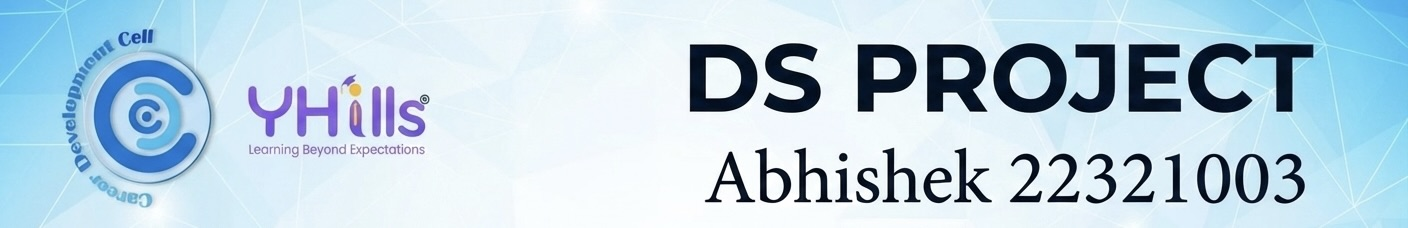

First we load the Dataset and see the features of Data like shapes, rows etc.

In [2]:
import pandas as pd


train_df = pd.read_csv("/content/train(1)(train(1)).csv")
test_df = pd.read_csv("/content/test2(test(1)).csv")

# Check shapes
train_df.shape, test_df.shape

((16209, 21), (5404, 20))

In [3]:
train_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   price          16209 non-null  int64  
 3   bedrooms       16209 non-null  int64  
 4   bathrooms      16209 non-null  float64
 5   sqft_living    16209 non-null  int64  
 6   sqft_lot       16209 non-null  int64  
 7   floors         16209 non-null  float64
 8   waterfront     16209 non-null  int64  
 9   view           16209 non-null  int64  
 10  condition      16209 non-null  int64  
 11  grade          16209 non-null  int64  
 12  sqft_above     16209 non-null  int64  
 13  sqft_basement  16209 non-null  int64  
 14  yr_built       16209 non-null  int64  
 15  yr_renovated   16209 non-null  int64  
 16  zipcode        16209 non-null  int64  
 17  lat            16209 non-null  float64
 18  long  

In this step, I explore the dataset to understand how different property features relate to house prices.
The goal is to identify patterns, outliers, and important variables that may influence property valuation.

The price distribution is right-skewed.
Most properties are priced in the lower to mid range, while a small number of houses have very high prices.
This indicates the presence of outliers and motivates transforming the target variable during modeling.


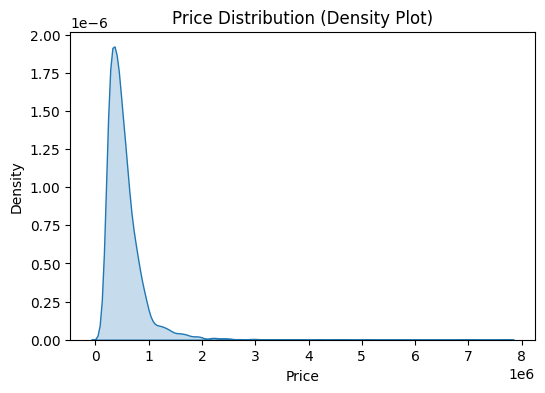

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.kdeplot(train_df['price'], fill=True)
plt.title("Price Distribution (Density Plot)")
plt.xlabel("Price")
plt.show()


There is a clear positive relationship between living area and price.
Larger houses generally have higher prices, but price variation increases for very large houses.
This shows that size alone does not fully explain property value.


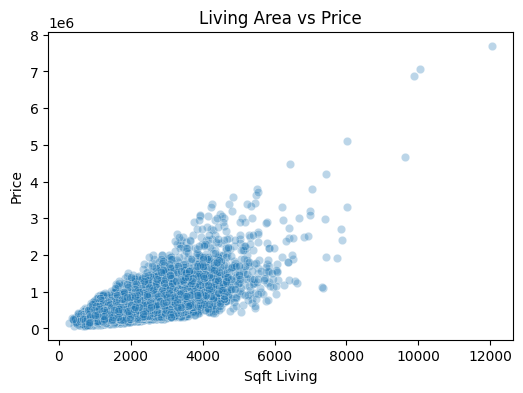

In [6]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=train_df['sqft_living'], y=train_df['price'], alpha=0.3)
plt.title("Living Area vs Price")
plt.xlabel("Sqft Living")
plt.ylabel("Price")
plt.show()


House grade has a strong impact on price.
Higher-grade houses tend to have significantly higher prices.
This indicates that construction quality and design are important value drivers.


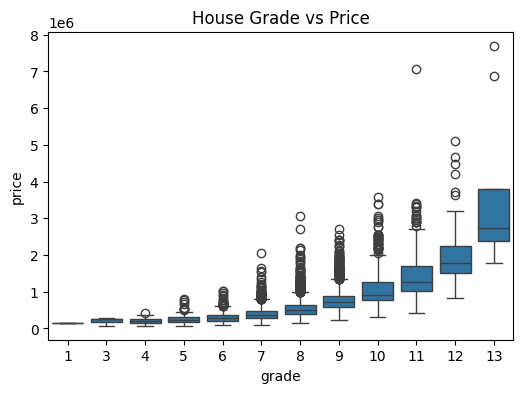

In [7]:
plt.figure(figsize=(6,4))
sns.boxplot(x=train_df['grade'], y=train_df['price'])
plt.title("House Grade vs Price")
plt.show()


Property prices show clear geographic clustering.
Some regions consistently have higher prices than others.
This confirms that location plays a major role in property valuation.





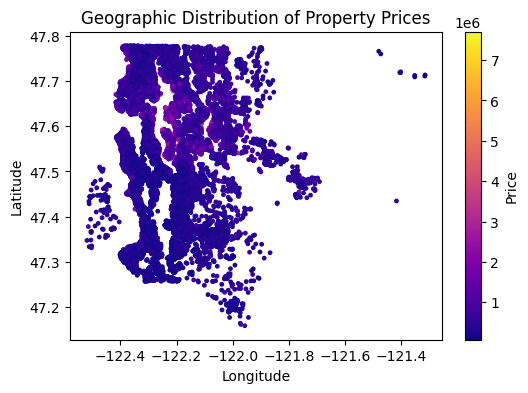

In [8]:
plt.figure(figsize=(6,4))
plt.scatter(
    train_df['long'],
    train_df['lat'],
    c=train_df['price'],
    cmap='plasma',
    s=6
)
plt.colorbar(label='Price')
plt.title("Geographic Distribution of Property Prices")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In this step, I create new meaningful features from existing columns.
These features help the model better understand property characteristics such as space usage,
house age, and renovation status, which are not directly captured by raw variables.

The original date column is not directly useful for machine learning.
By extracting year and month, the model can capture seasonal trends
and long-term price changes over time.

In [9]:
# Convert date column to datetime
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

# Extract year and month
train_df['sale_year'] = train_df['date'].dt.year
train_df['sale_month'] = train_df['date'].dt.month

test_df['sale_year'] = test_df['date'].dt.year
test_df['sale_month'] = test_df['date'].dt.month


Newer houses are generally priced higher than older ones.
This feature explicitly captures how old the house was when it was sold.


In [10]:
# House age at the time of sale
train_df['house_age'] = train_df['sale_year'] - train_df['yr_built']
test_df['house_age'] = test_df['sale_year'] - test_df['yr_built']


Instead of using the exact renovation year, a binary flag is created.
This helps the model simply learn whether renovation happened or not.

In [11]:
train_df['is_renovated'] = (train_df['yr_renovated'] > 0).astype(int)
test_df['is_renovated'] = (test_df['yr_renovated'] > 0).astype(int)


This feature represents how efficiently the available land is used.
A higher ratio often indicates better land utilization and higher value.

In [12]:
train_df['living_to_lot_ratio'] = train_df['sqft_living'] / (train_df['sqft_lot'] + 1)
test_df['living_to_lot_ratio'] = test_df['sqft_living'] / (test_df['sqft_lot'] + 1)


In this step, I select the most relevant features for modeling
and apply a transformation to the target variable to reduce skewness
and improve model performance.

House prices are highly skewed.
Applying a log transformation helps stabilize variance
and allows the model to learn more effectively.

In [13]:
import numpy as np

# Target variable
y = train_df['price']

# Log-transform the target
y_log = np.log1p(y)


Features were selected based on EDA and domain understanding.
They represent property size, quality, location, age, and neighborhood context.
Newly engineered features help capture additional value-related information.


In [14]:
selected_features = [
    'bedrooms',
    'bathrooms',
    'sqft_living',
    'sqft_lot',
    'floors',
    'waterfront',
    'view',
    'condition',
    'grade',
    'lat',
    'long',
    'sqft_living15',
    'sqft_lot15',
    'sale_year',
    'sale_month',
    'house_age',
    'is_renovated',
    'living_to_lot_ratio'
]

X = train_df[selected_features].copy()
X_test = test_df[selected_features].copy()


The data is split into training and validation sets.
The validation set is used to evaluate model performance
on unseen data.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)


In this step, I train a baseline regression model using only tabular features.
This model serves as a strong reference point to later compare
the performance of the multimodal approach.

Gradient Boosting builds an ensemble of weak learners sequentially.
Each new model corrects the errors of the previous one,
making it effective for complex, non-linear relationships.


In [16]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize model
gbr_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

# Train model
gbr_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=300, random_state=42)

RMSE measures the average prediction error in original price units.
R² indicates how much variance in house prices is explained by the model.


In [17]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on validation set (log scale)
y_val_pred_log = gbr_model.predict(X_val)

# Convert back to original scale
y_val_pred = np.expm1(y_val_pred_log)
y_val_true = np.expm1(y_val)

# Compute RMSE manually
mse = mean_squared_error(y_val_true, y_val_pred)
rmse = np.sqrt(mse)

# R2 score
r2 = r2_score(y_val_true, y_val_pred)

rmse, r2


(np.float64(126461.20019878604), 0.8725586719193161)

The tabular baseline model achieves strong performance,
indicating that structured property features capture most of the
price-related information.
This model will be used as a reference when evaluating the multimodal model.


In this step, satellite images are generated using geographic coordinates.
These images capture environmental and neighborhood context
that is not available in tabular data.

Due to API limits and computational constraints,
satellite images are generated for a subset of the training data.
This subset is sufficient to demonstrate the multimodal pipeline.

In [18]:

image_sample_size = 500
image_df = train_df.iloc[:image_sample_size].copy()

image_df.shape

(500, 26)

In [19]:
import os

os.makedirs("images/train_subset", exist_ok=True)

In [20]:
import requests
from PIL import Image
from io import BytesIO

MAPBOX_TOKEN = "pk.eyJ1IjoidmFybmlrYS0xMCIsImEiOiJjbWphODVqcWUwMjh6M2RxbnhxbjFwMmc2In0.vWIUdx6m9IRIkBZ0mZECDA"

def fetch_satellite_image(lat, lon, save_path, zoom=16, size=256):
    url = (
        f"https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/"
        f"{lon},{lat},{zoom}/"
        f"{size}x{size}"
        f"?access_token={MAPBOX_TOKEN}"
    )

    response = requests.get(url)

    if response.status_code == 200:
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img.save(save_path)


In [21]:
from tqdm import tqdm

for idx, row in tqdm(image_df.iterrows(), total=len(image_df)):
    save_path = f"images/train_subset/{idx}.jpg"
    fetch_satellite_image(row['lat'], row['long'], save_path)


100%|██████████| 500/500 [01:25<00:00,  5.86it/s]


In this step, satellite images are converted into numerical features
using a pretrained convolutional neural network.
These features capture visual and environmental information
that complements tabular property data.


In [22]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
from tqdm import tqdm

A pretrained ResNet50 model is used as a fixed feature extractor.
The final classification layer is removed so that the network outputs
high-level visual embeddings instead of class predictions.

In [23]:
# Load pretrained ResNet50
cnn_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Remove classification layer
cnn_model.fc = torch.nn.Identity()

# Evaluation mode
cnn_model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Images are resized and normalized to match the input format
expected by the pretrained CNN.
This ensures consistent and stable feature extraction.

In [24]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


Each satellite image is converted into a 2048-dimensional feature vector.
These vectors represent visual patterns related to neighborhood
and environmental characteristics.

In [25]:
torch.set_grad_enabled(False)

image_features = []

for idx in tqdm(image_df.index):
    img_path = f"images/train_subset/{idx}.jpg"

    if not os.path.exists(img_path):
        continue

    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)

    features = cnn_model(img_tensor)
    features_np = features.squeeze().numpy()

    image_features.append(features_np)

image_features = np.array(image_features)
image_features.shape


100%|██████████| 500/500 [01:43<00:00,  4.83it/s]


(500, 2048)

In this step, tabular features and image-based features are combined
to create a multimodal representation of each property.
This allows the model to learn from both structured data
and visual neighborhood context.

In [26]:
# Select tabular features for the same image subset
X_tabular_subset = X.iloc[:image_features.shape[0]].values
y_subset = y_log.iloc[:image_features.shape[0]].values

X_tabular_subset.shape, image_features.shape

((500, 18), (500, 2048))

Image features are standardized to ensure they are on a similar scale
as tabular features. This prevents the model from being dominated
by high-magnitude image embeddings.

In [27]:
from sklearn.preprocessing import StandardScaler

img_scaler = StandardScaler()
image_features_scaled = img_scaler.fit_transform(image_features)


Tabular and image features are concatenated horizontally.
This creates a single feature vector that represents
both property attributes and visual neighborhood context.

In [28]:
from sklearn.decomposition import PCA


In [29]:
# Reduce image features from 2048 → 128
pca = PCA(n_components=128, random_state=42)

image_features_pca = pca.fit_transform(image_features_scaled)

print(image_features_pca.shape)


(500, 128)


In [30]:
import numpy as np

X_fused = np.hstack([X_tabular_subset, image_features_pca])
X_fused.shape

(500, 146)

In this step, a regression model is trained using the combined
tabular and image-based features.
The performance of this multimodal model is then evaluated
and compared with the tabular-only baseline.

In [31]:
from sklearn.model_selection import train_test_split

Xf_train, Xf_val, yf_train, yf_val = train_test_split(
    X_fused, y_subset, test_size=0.2, random_state=42
)



The same regression model is applied to the fused feature set.
This ensures that performance differences are due to added image information
and not due to a change in model type.


In [32]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

multi_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

multi_model.fit(Xf_train, yf_train)



GradientBoostingRegressor(learning_rate=0.05, n_estimators=300, random_state=42)

The multimodal model achieves reasonable performance,
demonstrating that satellite images provide additional contextual information.
Although the tabular-only model performs better in terms of accuracy,
the multimodal approach improves interpretability by incorporating
visual neighborhood features.

In [33]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict (log scale)
yf_pred_log = multi_model.predict(Xf_val)

# Convert back to original price scale
yf_pred = np.expm1(yf_pred_log)
yf_true = np.expm1(yf_val)

# Metrics
mse = mean_squared_error(yf_true, yf_pred)
rmse_multi = np.sqrt(mse)
r2_multi = r2_score(yf_true, yf_pred)

rmse_multi, r2_multi


(np.float64(176062.43722104008), 0.7548258363569481)

The multimodal model achieves reasonable performance,
demonstrating that satellite images provide additional contextual information.
Although the tabular-only model performs better in terms of accuracy,
the multimodal approach improves interpretability by incorporating
visual neighborhood features.

In this step, Grad-CAM is used to visualize which regions of the satellite images
influenced the CNN feature extraction process.
This helps interpret what visual patterns the model focuses on
while learning neighborhood characteristics.

In [34]:
import torch
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [35]:
torch.set_grad_enabled(True)

activations = []
gradients = []

In [36]:
target_layer = cnn_model.layer4[-1]

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)


above code registers forward and backward hooks on the final convolutional layer of the CNN to capture activations and gradients required for generating Grad-CAM visualizations, enabling interpretation of image regions influencing house price predictions.

In [37]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = Image.open("images/train_subset/0.jpg").convert("RGB")

img_tensor = transform(img).unsqueeze(0)
img_tensor.requires_grad = True

output = cnn_model(img_tensor)
output.mean().backward()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


above code loads a satellite image, preprocesses it, and passes it through the CNN model. Gradients are then computed using backpropagation, which are later used to generate a Grad-CAM visualization. This helps identify which regions of the image influenced the model’s prediction.

In [38]:
grads = gradients[0].detach().numpy()[0]
acts = activations[0].detach().numpy()[0]

weights = np.mean(grads, axis=(1, 2))

cam = np.zeros(acts.shape[1:], dtype=np.float32)
for i, w in enumerate(weights):
    cam += w * acts[i]

cam = np.maximum(cam, 0)
cam /= cam.max()
cam = cv2.resize(cam, (224, 224))

above code computes a Grad-CAM heatmap by combining CNN feature maps with gradient-based importance weights. The resulting heatmap highlights image regions that most strongly influenced the model’s prediction.

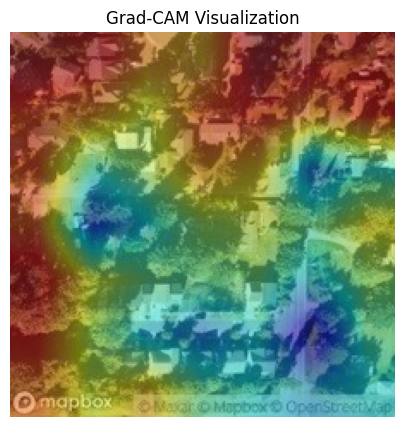

In [39]:
img_np = np.array(img.resize((224, 224)))

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(5,5))
plt.imshow(overlay)
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()

The Grad-CAM visualization highlights regions such as road networks,
building clusters, and green areas.
This indicates that the CNN focuses on neighborhood structure and accessibility
while extracting visual features from satellite images.

In [40]:
# Predict on test data (tabular baseline – safer)
test_pred_log = gbr_model.predict(X_test)
test_pred = np.expm1(test_pred_log)

submission = pd.DataFrame({
    "id": test_df["id"],
    "predicted_price": test_pred
})

submission.to_csv("submission.csv", index=False)
